In [1]:
# %run helper_functions_mileva.ipynb

In [2]:
# helper functions
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from average_precision import apk, mapk

# Helper functions for improving memory
# https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/308635
def customer_hex_id_to_int(series):
    return series.str[-16:].apply(hex_id_to_int)

def hex_id_to_int(str):
    return int(str[-16:], 16)

def article_id_str_to_int(series):
    return series.astype('int32')

def article_id_int_to_str(series):
    return '0' + series.astype('str')

# Transforms categorical columns into categorical types
class Categorize(BaseEstimator, TransformerMixin):
    def __init__(self, min_examples=0):
        self.min_examples = min_examples
        self.categories = []
        
    def fit(self, X):
        ''' Identifies the categorical variables in our data based on the number of unique value counts'''
        for i in range(X.shape[1]):
            vc = X.iloc[:, i].value_counts() # value counts for each column
            self.categories.append(vc[vc > self.min_examples].index.tolist()) # keeps columns whose value counts are large enough
        return self

    def transform(self, X):
        ''' Transforms the categorical variables into a categorical type (e.g. DCategorical)'''
        data = {X.columns[i]: pd.Categorical(X.iloc[:, i], categories=self.categories[i]).codes for i in range(X.shape[1])}
        return pd.DataFrame(data=data)

## 2. Read Data

In [3]:
import pandas as pd

transactions = pd.read_csv('data/transactions_train.csv', dtype={"article_id": "str"})
customers = pd.read_csv('data/customers.csv')
articles = pd.read_csv('data/articles.csv', dtype={"article_id": "str"})

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

## 3. Process Data

#### Apply memory reducing techniques to transactions.csv

In [ ]:
# Convert customer_id to int
transactions['customer_id'] = customer_hex_id_to_int(transactions['customer_id'])
transactions.info(memory_usage='deep')

In [ ]:
# Convert transaction dates to datetime
transactions.t_dat = pd.to_datetime(transactions.t_dat, format='%Y-%m-%d')

#### Computes week number, where week 0 are the transactions made in the first week of the data and week 104 are the transactions made in the final week of the data

In [ ]:
DURATION_IN_WEEKS = 104 # Transactions take place over 104 weeks
transactions['week'] = DURATION_IN_WEEKS - (transactions.t_dat.max() - transactions.t_dat).dt.days // 7

#### Apply memory reducing techniques to transactions.csv

In [ ]:
# Convert article_id, price, sales_channel_id, and week
transactions.article_id = article_id_str_to_int(transactions.article_id)
articles.article_id = article_id_str_to_int(articles.article_id)

transactions.week = transactions.week.astype('int8')
transactions.sales_channel_id = transactions.sales_channel_id.astype('int8')
transactions.price = transactions.price.astype('float32')

In [ ]:
transactions.info(memory_usage='deep')

#### Apply memory reducing techniques to customers.csv and articles.csv

In [ ]:
customers['club_member_status'].unique()

In [ ]:
# NA values in customer columns set to -1
customers.customer_id = customer_hex_id_to_int(customers.customer_id)
for col in ['FN', 'Active', 'age']:
    customers[col].fillna(-1, inplace=True)
    customers[col] = customers[col].astype('int8')

In [ ]:
customers.club_member_status = Categorize().fit_transform(customers[['club_member_status']]).club_member_status
customers.postal_code = Categorize().fit_transform(customers[['postal_code']]).postal_code
customers.fashion_news_frequency = Categorize().fit_transform(customers[['fashion_news_frequency']]).fashion_news_frequency

In [ ]:
for col in articles.columns:
    if articles[col].dtype == 'object':
        articles[col] = Categorize().fit_transform(articles[[col]])[col]

In [ ]:
for col in articles.columns:
    if articles[col].dtype == 'int64':
        articles[col] = articles[col].astype('int32')

## 4. Save preprocessed data in parquet files

In [ ]:
transactions.sort_values(['t_dat', 'customer_id'], inplace=True)

In [ ]:
transactions.to_parquet('data/transactions_train.parquet')
customers.to_parquet('data/customers.parquet')
articles.to_parquet('data/articles.parquet')

## 5. Sample preprocessed data and save 

In [ ]:
# let's create a 5% sample of the entiriety of the data to speed up dev
sample = 0.05
customers_sample = customers.sample(frac=sample, replace=False)
customers_sample_ids = set(customers_sample['customer_id'])
transactions_sample = transactions[transactions["customer_id"].isin(customers_sample_ids)]
articles_sample_ids = set(transactions_sample["article_id"])
articles_sample = articles[articles["article_id"].isin(articles_sample_ids)]

customers_sample.to_parquet(f'data/customers_sample_{sample}.parquet', index=False)
transactions_sample.to_parquet(f'data/transactions_train_sample_{sample}.parquet', index=False)
articles_sample.to_parquet(f'data/articles_train_sample_{sample}.parquet', index=False)

## 6. Evaluation

### Save validation set: a dictionary of all customers and the articles they purchased in the last week

Form: {'customer_id1': [article_id1, article_id2, ...], 'customer_id': [article_id1, article_id2, ...]}

In [ ]:
from collections import defaultdict

val_week_purchases_by_cust = defaultdict(list) # Required for the .map.apply in the following blocks
val_week_purchases_by_cust.update(
    transactions[transactions.week == transactions.week.max()]\
        .groupby('customer_id')['article_id']\
        .apply(list)\
        .to_dict()
)

# example format of val_week_purchases_by_cust
val_week_purchases_by_cust[1402273113592184] # key = 1402273113592184

save dictionary as pkl file

In [ ]:
pd.to_pickle(dict(val_week_purchases_by_cust), 'data/val_week_purchases_by_cust.pkl')

# Candidate Generation and LGBM

## 1. Setup and imports

* pip install pyarrow (for loading parquets)
* pip install lightgbm (May require installation of other packages: https://github.com/microsoft/LightGBM/tree/master/python-package)

In [193]:
import pandas as pd
import matplotlib as plt
import numpy as np

from average_precision import apk, mapk

All categorical columns in transactions, customers, and articles have been converted into a numerical code within the saved parquet. All NaN values were replaced with -1. LGBM models perform best when the categorical columns are encoded as integers. 

Next steps: 
* Imputation instead of replacing with -1 
* Remove any unnecessary columns?

## 2. Load data

In [127]:
transactions = pd.read_parquet('data/transactions_train.parquet')
customers = pd.read_parquet('data/customers.parquet')
articles = pd.read_parquet('data/articles.parquet')

### Transactions data

In [128]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week
25784,2018-09-20,1728846800780188,519773001,0.028458,2,0
25785,2018-09-20,1728846800780188,578472001,0.032525,2,0
5389,2018-09-20,2076973761519164,661795002,0.167797,2,0
5390,2018-09-20,2076973761519164,684080003,0.101678,2,0
47429,2018-09-20,2918879973994241,662980001,0.033881,1,0


In [129]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31788324 entries, 25784 to 31780475
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[ns]
 1   customer_id       uint64        
 2   article_id        int32         
 3   price             float32       
 4   sales_channel_id  int8          
 5   week              int8          
dtypes: datetime64[ns](1), float32(1), int32(1), int8(2), uint64(1)
memory usage: 1.0 GB


Number of transactions made per week

<AxesSubplot:title={'center':'Number of Transactions per Week'}>

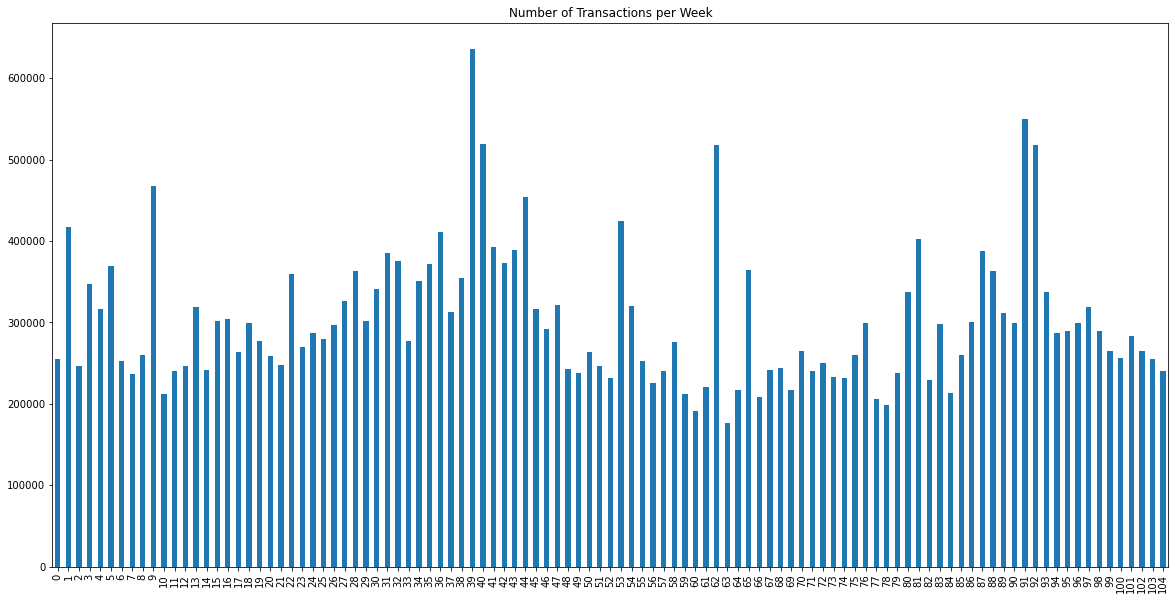

In [130]:
transactions['week']\
    .value_counts()\
    .sort_index()\
    .plot(figsize = (20, 10), kind='bar', title = 'Number of Transactions per Week')

### Customers data

In [131]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,6883939031699146327,-1,-1,0,0,49,6305
1,11246327431398957306,-1,-1,0,0,25,33726
2,18439897732908966680,-1,-1,0,0,24,3247
3,18352672461570950206,-1,-1,0,0,54,168643
4,18162778555210377306,1,1,0,1,52,168645


In [132]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   customer_id             1371980 non-null  uint64
 1   FN                      1371980 non-null  int8  
 2   Active                  1371980 non-null  int8  
 3   club_member_status      1371980 non-null  int8  
 4   fashion_news_frequency  1371980 non-null  int8  
 5   age                     1371980 non-null  int8  
 6   postal_code             1371980 non-null  int32 
dtypes: int32(1), int8(5), uint64(1)
memory usage: 22.2 MB


### Articles data

In [133]:
articles.head()
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   article_id                    105542 non-null  int32
 1   product_code                  105542 non-null  int32
 2   prod_name                     105542 non-null  int32
 3   product_type_no               105542 non-null  int32
 4   product_type_name             105542 non-null  int16
 5   product_group_name            105542 non-null  int8 
 6   graphical_appearance_no       105542 non-null  int32
 7   graphical_appearance_name     105542 non-null  int8 
 8   colour_group_code             105542 non-null  int32
 9   colour_group_name             105542 non-null  int8 
 10  perceived_colour_value_id     105542 non-null  int32
 11  perceived_colour_value_name   105542 non-null  int8 
 12  perceived_colour_master_id    105542 non-null  int32
 13  perceived_colo

## Obtain Ground Truth for Validation

In [134]:
val_week = transactions["week"].max()
val_week

104

In [135]:
val_ground_truth = transactions[transactions["week"] == val_week]\
    .groupby("customer_id")["article_id"]\
    .apply(list)\
    .to_dict()

In [136]:
pd.to_pickle(dict(val_ground_truth), 'data/val_ground_truth.pkl')

## 3. Subset data 

Identify customers with more than 15 transactions

In [137]:
# Customers with more than 1 transaction
num_transactions = transactions["customer_id"].value_counts()
customer_ids_retained = num_transactions[num_transactions > 15].index.tolist()
len(customer_ids_retained)

513076

Subsample customers, transactions, and articles

In [138]:
# Subsample of customers, transactions
customers_sample = customers[customers["customer_id"].isin(customer_ids_retained)]
transactions_sample = transactions[transactions["customer_id"].isin(customer_ids_retained)]

# Subsample of articles
article_ids_retained = set(transactions_sample["article_id"])
articles_sample = articles[articles["article_id"].isin(article_ids_retained)]

Explore subsamples

In [139]:
transactions_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27113639 entries, 25784 to 31780475
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[ns]
 1   customer_id       uint64        
 2   article_id        int32         
 3   price             float32       
 4   sales_channel_id  int8          
 5   week              int8          
dtypes: datetime64[ns](1), float32(1), int32(1), int8(2), uint64(1)
memory usage: 879.2 MB


Save subsamples

In [144]:
customers_sample.to_parquet(f'data/customers_sample_gt15transaction.parquet', index=False)
transactions_sample.to_parquet(f'data/transactions_train_sample_gt15transaction.parquet', index=False)
articles_sample.to_parquet(f'data/articles_train_sample_gt15transaction.parquet', index=False)

## 4. Load subsetted data

In [145]:
customers = pd.read_parquet('data/customers_sample_gt15transaction.parquet')
transactions = pd.read_parquet('data/transactions_train_sample_gt15transaction.parquet')
articles = pd.read_parquet('data/articles_train_sample_gt15transaction.parquet')

## 5. Train, validation, test split

In [146]:
train_transactions = transactions[transactions["week"] != val_week] 
val_transactions = transactions[transactions["week"] == val_week]

## 1. Define training and testing weeks

In [156]:
# We're testing for week 105. The week after the final week given in the dataset
test_week = transactions.week.max() + 1 

# only uses the last 10 weeks of transactions
transactions = transactions[transactions.week > transactions.week.max() - 10]

In [157]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week
24810231,2020-07-15,272412481300040,778064028,0.008458,1,95
24810232,2020-07-15,272412481300040,816592008,0.016932,1,95
24810233,2020-07-15,272412481300040,621381021,0.033881,1,95
24810234,2020-07-15,272412481300040,817477003,0.025407,1,95
24810235,2020-07-15,272412481300040,899088002,0.025407,1,95


## 2. Generating candidates

#### Last purchase candidates - I'm unsure about the purpose of this section. I believe it's trying to identify the articles a customer has purchased previously or in the last week. 

For each customer, list the weeks when they made purchases

In [158]:
c2weeks = transactions.groupby('customer_id')['week'].unique()
c2weeks

customer_id
28847241659200          [95, 96, 101, 102]
41318098387474                        [98]
116809474287335                 [101, 103]
200292573348128          [95, 96, 99, 102]
248294615847351                       [96]
                               ...        
18446420423308293068            [102, 103]
18446566209623725451                  [99]
18446571879212697038              [95, 98]
18446590778427270109             [97, 102]
18446737527580148316                 [104]
Name: week, Length: 293715, dtype: object

Another representation of c2weeks (weeks when customers made purchases) <br>
Form {'customer_id': dict_of_shifted_weeks}. I'm not yet sure why they want data in this form

In [159]:
c2weeks2shifted_weeks = {}

for c_id, weeks in c2weeks.items():
    c2weeks2shifted_weeks[c_id] = {}
    for i in range(weeks.shape[0]-1):
        c2weeks2shifted_weeks[c_id][weeks[i]] = weeks[i+1]
    c2weeks2shifted_weeks[c_id][weeks[-1]] = test_week
    
c2weeks2shifted_weeks[272412481300040]

{95: 96, 96: 103, 103: 105}

Shifts the 'week' recorded for each transaction. If the first purchase was made in week 95 and the next purchase was in week 97, records week 97. I don't know why though

In [160]:
candidates_last_purchase = transactions.copy()

weeks = []
for i, (c_id, week) in enumerate(zip(transactions['customer_id'], transactions['week'])):
    # print(i, c_id, week)
    weeks.append(c2weeks2shifted_weeks[c_id][week])
    # print(c2weeks2shifted_weeks[c_id][week])

candidates_last_purchase.week=weeks
candidates_last_purchase

,t_dat,customer_id,article_id,price,sales_channel_id,week
24810231,2020-07-15,272412481300040,778064028,0.008458,1,96
24810232,2020-07-15,272412481300040,816592008,0.016932,1,96
24810233,2020-07-15,272412481300040,621381021,0.033881,1,96
24810234,2020-07-15,272412481300040,817477003,0.025407,1,96
24810235,2020-07-15,272412481300040,899088002,0.025407,1,96
...,...,...,...,...,...,...
27113634,2020-09-22,18437941771381362708,907188001,0.050831,2,105
27113635,2020-09-22,18437941771381362708,907188001,0.050831,2,105
27113636,2020-09-22,18439937050817258297,891591003,0.084729,2,105
27113637,2020-09-22,18439937050817258297,869706005,0.084729,2,105


### Bestsellers candidates - identify the top 12 bestselling articles per week

Average price of each article in a given week


In [161]:
mean_price = transactions \
    .groupby(['week', 'article_id'])['price'].mean()
mean_price

week  article_id
95    108775015     0.004729
      108775044     0.008458
      110065002     0.006085
      111565001     0.004076
      111586001     0.011375
                      ...   
104   952267001     0.014045
      952938001     0.048651
      953450001     0.016932
      953763001     0.021859
      956217002     0.059068
Name: price, Length: 187563, dtype: float32

Top 12 bestselling items per week

In [162]:
# 1. number of times each article was sold in a given week
# 2. rank so most popular item is at the top ( == 1)
# 3. For each week get the top 12 items based on rank
sales = transactions\
    .groupby('week')['article_id'].value_counts()\
    .groupby('week').rank(method='dense', ascending=False)\
    .groupby('week').head(12).rename('bestseller_rank').astype('int8') 
sales

week  article_id
95    866731001      1
      760084003      2
      372860002      3
      600886001      4
      706016001      5
                    ..
104   915529005      8
      762846027      9
      915529003      9
      448509014     10
      714790020     11
Name: bestseller_rank, Length: 120, dtype: int8

Merges the two previous dataframes to get the bestsellers and prices of the articles (per week) from the previous week 

In [163]:
# the same article may appear multiple times
bestsellers_previous_week = pd.merge(sales, mean_price, on=['week', 'article_id']).reset_index()
bestsellers_previous_week.week += 1
bestsellers_previous_week

,week,article_id,bestseller_rank,price
0,96,866731001,1,0.024932
1,96,760084003,2,0.025113
2,96,372860002,3,0.013192
3,96,600886001,4,0.022483
4,96,706016001,5,0.033166
...,...,...,...,...
115,105,915529005,8,0.033417
116,105,762846027,9,0.025042
117,105,915529003,9,0.033445
118,105,448509014,10,0.041622


Each record represents a distinct (customer, week) tuple. <br>
Thus, if a customer made multiple transactions in the same week only one row is reported. This table is used in the next step.

In [164]:
unique_transactions = transactions \
    .groupby(['week', 'customer_id']) \
    .head(1) \
    .drop(columns=['article_id', 'price']) \
    .copy()
unique_transactions

,t_dat,customer_id,sales_channel_id,week
24810231,2020-07-15,272412481300040,1,95
24810236,2020-07-15,1456826891333599,1,95
24810238,2020-07-15,6010692573790711,1,95
24810244,2020-07-15,6171059100114610,2,95
24810246,2020-07-15,6434044519214559,2,95
...,...,...,...,...
27113626,2020-09-22,18432411165497420051,1,104
27113627,2020-09-22,18432753550436772025,2,104
27113630,2020-09-22,18435221511488011015,1,104
27113632,2020-09-22,18436859303155335645,1,104


Merges the bestseller information (week, article, bestseller rank, and price) with the customer who purchased that item.

In [165]:
candidates_bestsellers = pd.merge(
    unique_transactions,
    bestsellers_previous_week,
    on='week',
)
candidates_bestsellers

,t_dat,customer_id,sales_channel_id,week,article_id,bestseller_rank,price
0,2020-07-22,200292573348128,2,96,866731001,1,0.024932
1,2020-07-22,200292573348128,2,96,760084003,2,0.025113
2,2020-07-22,200292573348128,2,96,372860002,3,0.013192
3,2020-07-22,200292573348128,2,96,600886001,4,0.022483
4,2020-07-22,200292573348128,2,96,706016001,5,0.033166
...,...,...,...,...,...,...,...
6243187,2020-09-22,18437941771381362708,2,104,448509014,8,0.041764
6243188,2020-09-22,18437941771381362708,2,104,809238005,8,0.041678
6243189,2020-09-22,18437941771381362708,2,104,915529003,9,0.033474
6243190,2020-09-22,18437941771381362708,2,104,918292001,10,0.041604


In [166]:
# Transactions for the test set (from last week of data)
test_set_transactions = unique_transactions.drop_duplicates('customer_id').reset_index(drop=True)
test_set_transactions.week = test_week

# Combine with bestsellers info
candidates_bestsellers_test_week = pd.merge(
    test_set_transactions,
    bestsellers_previous_week,
    on='week'
)
candidates_bestsellers

,t_dat,customer_id,sales_channel_id,week,article_id,bestseller_rank,price
0,2020-07-22,200292573348128,2,96,866731001,1,0.024932
1,2020-07-22,200292573348128,2,96,760084003,2,0.025113
2,2020-07-22,200292573348128,2,96,372860002,3,0.013192
3,2020-07-22,200292573348128,2,96,600886001,4,0.022483
4,2020-07-22,200292573348128,2,96,706016001,5,0.033166
...,...,...,...,...,...,...,...
6243187,2020-09-22,18437941771381362708,2,104,448509014,8,0.041764
6243188,2020-09-22,18437941771381362708,2,104,809238005,8,0.041678
6243189,2020-09-22,18437941771381362708,2,104,915529003,9,0.033474
6243190,2020-09-22,18437941771381362708,2,104,918292001,10,0.041604


In [167]:
candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_test_week])
candidates_bestsellers.drop(columns='bestseller_rank', inplace=True)
candidates_bestsellers

,t_dat,customer_id,sales_channel_id,week,article_id,price
0,2020-07-22,200292573348128,2,96,866731001,0.024932
1,2020-07-22,200292573348128,2,96,760084003,0.025113
2,2020-07-22,200292573348128,2,96,372860002,0.013192
3,2020-07-22,200292573348128,2,96,600886001,0.022483
4,2020-07-22,200292573348128,2,96,706016001,0.033166
...,...,...,...,...,...,...
3524575,2020-09-22,18421175435799911749,2,105,915529005,0.033417
3524576,2020-09-22,18421175435799911749,2,105,762846027,0.025042
3524577,2020-09-22,18421175435799911749,2,105,915529003,0.033445
3524578,2020-09-22,18421175435799911749,2,105,448509014,0.041622


## 3. Combining transactions and candidates / negative examples

Label all transactions across all weeks as 1 (positive samples)

Comment from Pawel in Kaggle discussion here: https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/307288
In my setting I propose to convert the problem to a table where you have a list of item candidates and you mark the sales as either 0 or 1 depending whether the item was sold in the next week. Imagine you want to create negative samples as a list of 1000 most popular items in the last week. Some of those items will be bought by the customers. So the table you need to create is:
customer_id
label = whether it was bought or not
article_id from the list of 1000 most popular items
I'm not saying this is the best approach here but it is more or less what I'm doing. This is a technique where you create a set of explicit negative items. There are also techniques for implicit recommendations but all of them assume some sort of a strategy to generate negative samples.

In [168]:
transactions['purchased'] = 1 
transactions.shape

(2303408, 7)

In [169]:
data = pd.concat([transactions, candidates_last_purchase, candidates_bestsellers])
data.purchased.fillna(0, inplace=True) # Label all candidate generated transactions as 0

# Drops duplicates. Retains the transactions (positive labels). If duplicated, will drop the duplicates in the negative samples
data.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True) 
data

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased
24810231,2020-07-15,272412481300040,778064028,0.008458,1,95,1.0
24810232,2020-07-15,272412481300040,816592008,0.016932,1,95,1.0
24810233,2020-07-15,272412481300040,621381021,0.033881,1,95,1.0
24810234,2020-07-15,272412481300040,817477003,0.025407,1,95,1.0
24810235,2020-07-15,272412481300040,899088002,0.025407,1,95,1.0
...,...,...,...,...,...,...,...
3524575,2020-09-22,18421175435799911749,915529005,0.033417,2,105,0.0
3524576,2020-09-22,18421175435799911749,762846027,0.025042,2,105,0.0
3524577,2020-09-22,18421175435799911749,915529003,0.033445,2,105,0.0
3524578,2020-09-22,18421175435799911749,448509014,0.041622,2,105,0.0


### Add bestseller information

In [170]:
data = pd.merge(
    data,
    bestsellers_previous_week[['week', 'article_id', 'bestseller_rank']],
    on=['week', 'article_id'],
    how='left'
)

In [171]:
data = data[data.week != data.week.min()]
data.bestseller_rank.fillna(999, inplace=True)

In [172]:
data = pd.merge(data, articles, on='article_id', how='left')
data = pd.merge(data, customers, on='customer_id', how='left')

In [173]:
data.sort_values(['week', 'customer_id'], inplace=True)
data.reset_index(drop=True, inplace=True)

## 4. Train/ Test data

In [174]:
train = data[data.week != test_week]
train.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,bestseller_rank,product_code,prod_name,...,section_name,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,2020-07-26,28847241659200,887770001,0.016932,1,96,1.0,999.0,887770,727,...,10,1010,6,3692,1,1,0,1,21,57896
1,2020-07-18,28847241659200,762846001,0.025407,1,96,0.0,999.0,762846,472,...,7,1010,6,492,1,1,0,1,21,57896
2,2020-07-18,28847241659200,829308001,0.033881,1,96,0.0,999.0,829308,11402,...,21,1005,0,9082,1,1,0,1,21,57896
3,2020-07-26,28847241659200,866731001,0.024932,1,96,0.0,1.0,866731,3609,...,21,1005,0,3130,1,1,0,1,21,57896
4,2020-07-26,28847241659200,760084003,0.025113,1,96,0.0,2.0,760084,1134,...,1,1009,5,847,1,1,0,1,21,57896


In [175]:
test = data[data.week==test_week].drop_duplicates(['customer_id', 'article_id', 'sales_channel_id']).copy()
test.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,bestseller_rank,product_code,prod_name,...,section_name,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
9038352,2020-09-03,28847241659200,925246001,0.128797,2,105,0.0,999.0,925246,25454,...,40,1007,9,27855,1,1,0,1,21,57896
9038353,2020-07-18,28847241659200,924243001,0.041596,1,105,0.0,1.0,924243,19190,...,0,1003,3,13007,1,1,0,1,21,57896
9038354,2020-07-18,28847241659200,924243002,0.041922,1,105,0.0,2.0,924243,19190,...,0,1003,3,13007,1,1,0,1,21,57896
9038355,2020-07-18,28847241659200,923758001,0.033514,1,105,0.0,3.0,923758,19359,...,0,1010,6,27869,1,1,0,1,21,57896
9038356,2020-07-18,28847241659200,909370001,0.032548,1,105,0.0,4.0,909370,23319,...,0,1023,19,28617,1,1,0,1,21,57896


In [176]:
# Not yet sure what these are
train_baskets = train.groupby(['week', 'customer_id'])['article_id'].count().values
train_baskets

array([15, 23, 16, ..., 14, 19, 16])

Only use a subset of columns specified here as input into the LGBM model

In [177]:
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank']

### Model input

In [178]:
train_X = train[columns_to_use]
train_y = train['purchased']

test_X = test[columns_to_use]

In [179]:
train_X.head()

,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,bestseller_rank
0,887770001,253,1010016,9,4,5,1510,0,1,6,1010,1,1,0,1,21,57896,999.0
1,762846001,259,1010016,10,3,9,1515,0,1,11,1010,1,1,0,1,21,57896,999.0
2,829308001,273,1010016,9,4,5,8310,9,26,5,1005,1,1,0,1,21,57896,999.0
3,866731001,273,1010016,9,4,5,8310,9,26,5,1005,1,1,0,1,21,57896,1.0
4,760084003,272,1010016,9,4,5,1747,1,2,53,1009,1,1,0,1,21,57896,2.0


## 5. Model training

In [180]:
from lightgbm.sklearn import LGBMRanker

In [181]:
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)

In [182]:
# not sure what group = train_baskets is for
ranker = ranker.fit(
    train_X,
    train_y,
    group=train_baskets,
)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.847452
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.151124
[LightGBM] [Debug] init for col-wise cost 0.149272 seconds, init for row-wise cost 0.271560 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.247343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1083
[LightGBM] [Info] Number of data points in the train set: 9038352, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10


In [183]:
# Obtain feature importances
for i in ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], ranker.feature_importances_[i]/ranker.feature_importances_.sum())

bestseller_rank 0.9988409533944292
article_id 0.0003306247247705103
garment_group_no 0.00028507878138234085
product_type_no 0.00019254250639410466
department_no 9.313454815844396e-05
age 7.963306470924884e-05
colour_group_code 7.635760856561109e-05
section_no 6.617312984576725e-05
graphical_appearance_no 2.1137707720979766e-05
index_code 1.4364534023752177e-05
fashion_news_frequency 0.0
club_member_status 0.0
Active 0.0
FN 0.0
postal_code 0.0
perceived_colour_master_id 0.0
perceived_colour_value_id 0.0
index_group_no 0.0


## 6. Calculate predictions

In [184]:
# Predict on test_X
# Add the predictions to the test data (with customer and article id)
test['preds'] = ranker.predict(test_X)
test.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,bestseller_rank,product_code,prod_name,...,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,preds
9038352,2020-09-03,28847241659200,925246001,0.128797,2,105,0.0,999.0,925246,25454,...,1007,9,27855,1,1,0,1,21,57896,0.182298
9038353,2020-07-18,28847241659200,924243001,0.041596,1,105,0.0,1.0,924243,19190,...,1003,3,13007,1,1,0,1,21,57896,-0.167582
9038354,2020-07-18,28847241659200,924243002,0.041922,1,105,0.0,2.0,924243,19190,...,1003,3,13007,1,1,0,1,21,57896,-0.167582
9038355,2020-07-18,28847241659200,923758001,0.033514,1,105,0.0,3.0,923758,19359,...,1010,6,27869,1,1,0,1,21,57896,-0.197375
9038356,2020-07-18,28847241659200,909370001,0.032548,1,105,0.0,4.0,909370,23319,...,1023,19,28617,1,1,0,1,21,57896,-0.192451


In [185]:
# Obtain the products for each customer, based on highest predictions.
c_id2predicted_article_ids = test \
    .sort_values(['customer_id', 'preds'], ascending=False) \
    .groupby('customer_id')['article_id'].apply(list).to_dict()

c_id2predicted_article_ids[28847241659200] # predicted articles for person 28847241659200

[925246001,
 924243001,
 924243002,
 918522001,
 915529005,
 915529003,
 909370001,
 751471001,
 866731001,
 762846027,
 448509014,
 714790020,
 923758001]

In [186]:
# last weeks best sellers will be used in case fewer than 12 recommendations for a customer are made
bestsellers_last_week = \
    bestsellers_previous_week[bestsellers_previous_week.week == bestsellers_previous_week.week.max()]['article_id'].tolist()

## 7. Evaluate results

Mileva has to continue from here. Still figuring out how this code is working.

In [195]:
val_week_purchases_by_cust = pd.read_pickle('data/val_week_purchases_by_cust.pkl')

In [188]:
val_week_purchases_by_cust = pd.read_pickle('data/val_ground_truth.pkl')

In [196]:
apks = []

# If the ranking algorithm proposes fewer than 12 items. Pad with the top best sellers from the previous week
for c_id, gt in val_week_purchases_by_cust.items():
    pred = c_id2predicted_article_ids.get(c_id, [])
    pred = pred + bestsellers_last_week
    apks.append(apk(gt, pred[:12]))

np.mean(apks)

0.6943469766314992

## 8. Create submission

In [ ]:
sub = pd.read_csv('data/sample_submission.csv')

In [ ]:
%%time
preds = []
for c_id in customer_hex_id_to_int(sub.customer_id):
    pred = c_id2predicted_article_ids.get(c_id, [])
    pred = pred + bestsellers_last_week
    preds.append(pred[:12])

In [ ]:
preds = [' '.join(['0' + str(p) for p in ps]) for ps in preds]
sub.prediction = preds

In [ ]:
# sub_name = 'basic_model_submission'
# sub.to_csv(f'data/subs/{sub_name}.csv.gz', index=False)

In [ ]:
# !kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f 'data/subs/{sub_name}.csv.gz' -m {sub_name}